In [5]:
# load annotations and predictions
import os
import sys
import csv

import pandas as pd


In [6]:
jamendo_df = pd.read_csv("jamendolyrics/JamendoLyrics.csv")
pred_path = "data_pipeline/{lang}/predictions_{model}/{title}_align.csv"
ann_path = "data_pipeline/{lang}/annotations/{title}.words.csv"

models = ["baseline", "bdr_baseline", "MTL", "bdr_MTL"]
languages = ["English", "German", "Spanish", "French"]

In [7]:
if not os.path.exists("all_results.csv"):

    # Create an empty dataframe to store all results
    all_results_df = pd.DataFrame(columns=["title", "language", "model", "start", "end"])

    # Go over all titles
    for idx, row in jamendo_df.iterrows():
        title = row["Filepath"][:-4]
        lang = row["Language"]
        
        # Define file paths
        ann_file = ann_path.format(lang=lang, title=title)
        pred_files = {model: pred_path.format(lang=lang, model=model, title=title) for model in models}
        
        # Check if all required files exist
        if not os.path.exists(ann_file):
            print(f"Missing {ann_file}")
            continue
            
        missing_files = False
        for model, file_path in pred_files.items():
            if not os.path.exists(file_path):
                print(f"Missing {file_path}")
                missing_files = True
        
        if missing_files:
            continue
        
        print(f"Processing {title}")
        
        # Load annotations
        ann_df = pd.read_csv(ann_file)
        
        # Add annotations to all_results_df
        for i, ann_row in ann_df.iterrows():
            new_row = {"title": title, "language": lang, "model": "annotation", 
                    "start": ann_row["word_start"], "end": ann_row["word_end"]}
            all_results_df.loc[len(all_results_df)] = new_row
        
        # Process predictions for each model
        for model, pred_file in pred_files.items():
            with open(pred_file, newline='', encoding='utf-8') as csvfile:
                csvreader = csv.reader(csvfile)
                for pred_row in csvreader:
                    if len(pred_row) >= 2:  # Ensure there are at least 2 elements
                        new_row = {"title": title, "language": lang, "model": model,
                                "start": float(pred_row[0]), "end": float(pred_row[1])}
                        all_results_df.loc[len(all_results_df)] = new_row

    # Save the results
    all_results_df.to_csv("all_results.csv", index=False)

else:
    all_results_df = pd.read_csv("all_results.csv")

In [8]:
import pandas as pd

def calculate_correct_onset_percentage(annotations, predictions, tau):
    """
    Calculate the mean percentage of correctly estimated onsets for a given song and model.
    
    Parameters:
        annotations (pd.DataFrame): DataFrame with ground truth start times.
        predictions (pd.DataFrame): DataFrame with predicted start times.
        tau (float): The threshold in seconds for considering an estimate correct.
    
    Returns:
        float: The percentage of correctly estimated onsets for the song.
    """
    N_k = len(annotations)
    
    if N_k == 0 or len(predictions) == 0:
        return None  # Avoid division by zero
    
    assert N_k == len(predictions), f"Mismatch in annotation and prediction counts for {annotations.iloc[0]['title']}"
    
    correct_onsets = sum(1 for ann, pred in zip(annotations['start'], predictions['start']) if abs(pred - ann) < tau)
    
    return (correct_onsets / N_k) * 100  # Percentage for the song

# Define a threshold (τ) in seconds
tau = 0.3 

# Store results
aae_results = []
onset_results = []

# Group by language, title, and model
grouped = all_results_df.groupby(['language', 'title', 'model'])

for (language, title, model), group in grouped:
    if model == 'annotation':
        continue  # Skip ground truth entries
    
    # Extract corresponding ground truth annotations
    annotations = all_results_df[(all_results_df['language'] == language) & 
                                 (all_results_df['title'] == title) & 
                                 (all_results_df['model'] == 'annotation')].sort_values(by='start')
    
    predictions = group.sort_values(by='start')
    
    if len(annotations) == 0 or len(predictions) == 0:
        continue  # Skip if no data
    
    assert len(annotations) == len(predictions), f"Number of annotations and predictions do not match for {title} and model {model}"

    # Compute AAE
    abs_diffs = []
    for (ann_start, ann_end), (pred_start, pred_end) in zip(annotations[['start', 'end']].values, predictions[['start', 'end']].values):
        abs_diffs.append(abs(ann_start - pred_start))
        abs_diffs.append(abs(ann_end - pred_end))
    
    aae = sum(abs_diffs) / len(abs_diffs)
    aae_results.append({'language': language, 'title': title, 'AAE': aae, 'model': model})

    # Compute the correct onset percentage
    correct_percentage = calculate_correct_onset_percentage(annotations, predictions, tau)
    
    # Store results
    onset_results.append({'language': language, 'title': title, 'model': model, 'Correct Onset %': correct_percentage})

# Convert results to DataFrames
aae_df = pd.DataFrame(aae_results)
onset_df = pd.DataFrame(onset_results)



In [9]:
# Display results in LaTeX format, average for each Language and Model combination
print("AAE Results:")
print(aae_df.groupby(['language', 'model']).mean().to_latex())

print("\nCorrect Onset Percentage Results:")
print(onset_df.groupby(['language', 'model']).mean().to_latex())

AAE Results:
\begin{tabular}{llr}
\toprule
        &              &       AAE \\
language & model &           \\
\midrule
English & MTL &  0.459172 \\
        & baseline &  0.438356 \\
        & bdr\_MTL &  0.459714 \\
        & bdr\_baseline &  0.438476 \\
French & MTL &  0.757325 \\
        & baseline &  0.468690 \\
        & bdr\_MTL &  0.751963 \\
        & bdr\_baseline &  0.468148 \\
German & MTL &  0.414140 \\
        & baseline &  0.589698 \\
        & bdr\_MTL &  0.413522 \\
        & bdr\_baseline &  0.588422 \\
Spanish & MTL &  0.426553 \\
        & baseline &  0.367045 \\
        & bdr\_MTL &  0.426608 \\
        & bdr\_baseline &  0.380466 \\
\bottomrule
\end{tabular}


Correct Onset Percentage Results:
\begin{tabular}{llr}
\toprule
        &              &  Correct Onset \% \\
language & model &                  \\
\midrule
English & MTL &        93.360609 \\
        & baseline &        93.079287 \\
        & bdr\_MTL &        93.406314 \\
        & bdr\_baseline &       

/var/folders/tz/nj1np8hj5sn9b_q8m1628ssr0000gn/T/ipykernel_1779/1524793560.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(aae_df.groupby(['language', 'model']).mean().to_latex())
/var/folders/tz/nj1np8hj5sn9b_q8m1628ssr0000gn/T/ipykernel_1779/1524793560.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(aae_df.groupby(['language', 'model']).mean().to_latex())
/var/folders/tz/nj1np8hj5sn9b_q8m1628ssr0000gn/T/ipykernel_1779/1524793560.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecat

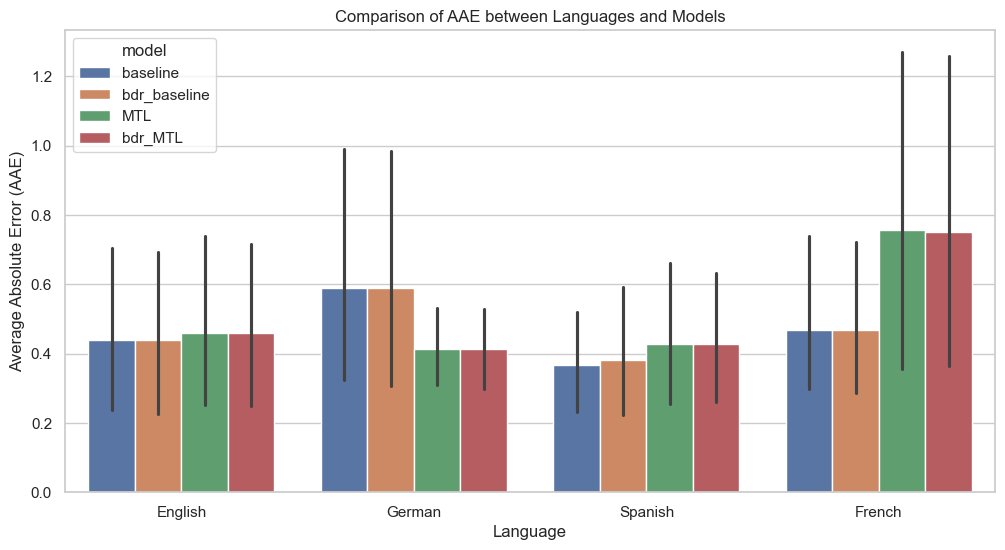

In [10]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set the plot style
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x="language", y="AAE", hue="model", data=aae_df, hue_order=models, order=languages)

# Set plot labels and title
plt.xlabel("Language")
plt.ylabel("Average Absolute Error (AAE)")
plt.title("Comparison of AAE between Languages and Models")

# Show the plot
plt.show()

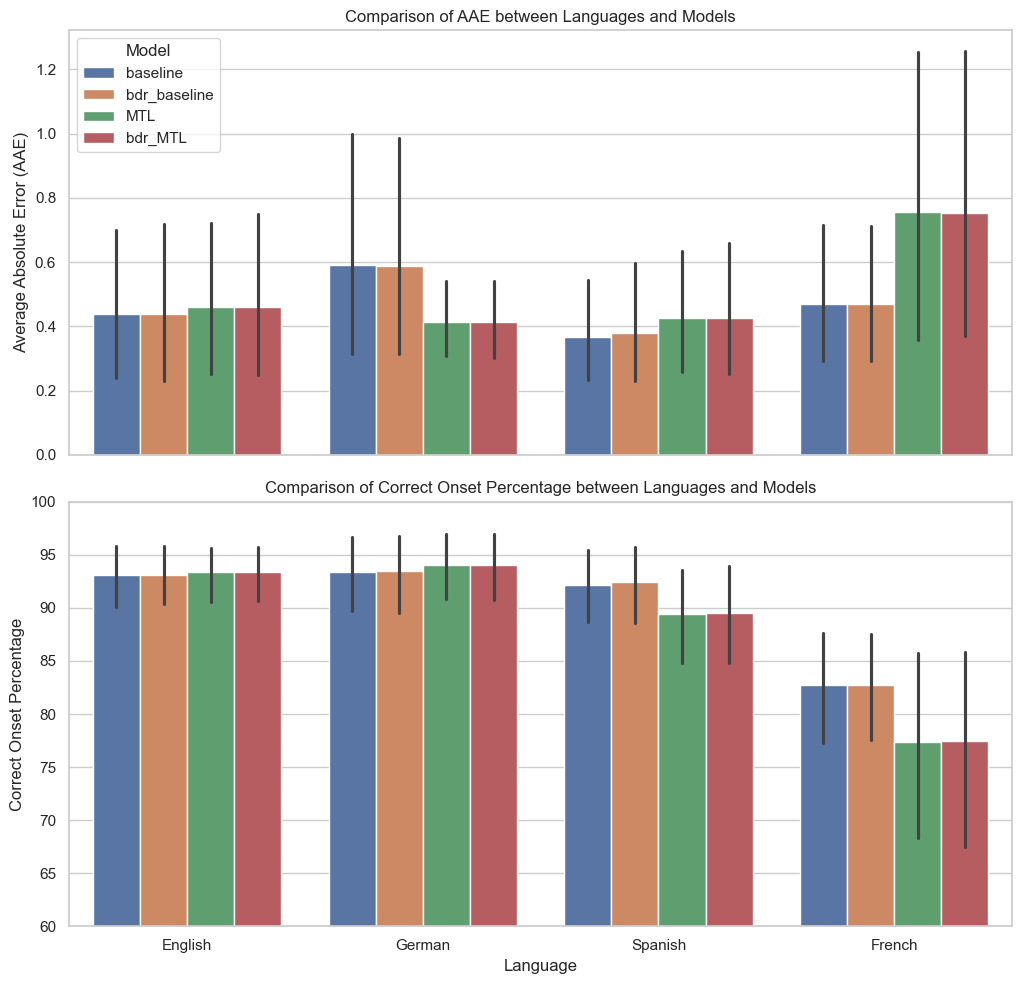

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the plot style
sns.set(style="whitegrid")

# Create a figure with two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# First subplot: AAE
sns.barplot(x="language", y="AAE", hue="model", data=aae_df, 
            hue_order=models, order=languages, ax=ax1)
ax1.set_ylabel("Average Absolute Error (AAE)")
ax1.set_title("Comparison of AAE between Languages and Models")
ax1.legend(title="Model",  loc='upper left')

# Second subplot: Correct Onset Percentage
sns.barplot(x="language", y="Correct Onset %", hue="model", data=onset_df, 
            hue_order=models, order=languages, ax=ax2)
ax2.set_xlabel("Language")
ax2.set_ylabel("Correct Onset Percentage")
ax2.set_title("Comparison of Correct Onset Percentage between Languages and Models")
ax2.set_ylim(60, 100)
# Remove legend from second plot to avoid duplication
ax2.get_legend().remove()

# Adjust layout to make room for legends and prevent overlap
plt.tight_layout()
fig.subplots_adjust(right=0.85)

# Show the plot
plt.show()